# Power Transform

Xuefeng Xu  
2025-04-14

Power transforms are parametric methods that convert data into a
Gaussian-like distribution. Two widely used transformations in this
category are the Box-Cox (Box and Cox 1964) and Yeo-Johnson (I. Yeo and
Johnson 2000) methods, both of which rely on a single parameter
$\lambda$.

## 1 Two Transformations

The Box-Cox transformation requires strictly positive data ($x > 0$) and
is defined as:

<span id="eq-box-cox">$$
\psi_{\text{BC}}(\lambda, x) =
\begin{cases}
\frac{x^\lambda-1}{\lambda} & \text{if } \lambda\neq0,\\
\ln x & \text{if } \lambda=0.
\end{cases}
 \qquad(1)$$</span>

The Yeo-Johnson transformation generalizes Box-Cox to handle
non-positive values and is defined as:

<span id="eq-yeo-johnson">$$
\psi_{\text{YJ}}(\lambda, x) =
\begin{cases}
\frac{(x+1)^\lambda-1}{\lambda} & \text{if } \lambda\neq0,x\ge0,\\
\ln(x+1) & \text{if } \lambda=0,x\ge0,\\
-\frac{(-x+1)^{2-\lambda}-1}{2-\lambda} & \text{if } \lambda\neq2,x<0,\\
-\ln(-x+1) & \text{if } \lambda=2,x<0.\\
\end{cases}
 \qquad(2)$$</span>

<a href="#fig-power-transform" class="quarto-xref">Figure 1</a>
visualizes these transformations across various $\lambda$ values.

In [1]:
import numpy as np
from scipy.special import boxcox
from scipy.stats import yeojohnson
import matplotlib.pyplot as plt

def power_plot(x_min, x_max, power):
    if power == "BC":
        power_func = boxcox
    else:
        power_func = yeojohnson

    eps = 0.01
    x = np.arange(x_min, x_max, eps)

    fig, ax = plt.subplots()
    line_color = ['dodgerblue', 'limegreen', 'red', 'mediumpurple', 'orange']
    for idx, lmb in enumerate([3, 2, 1, 0, -1]):
        y = power_func(x, lmb)
        ax.plot(x, y, label=fr'$\lambda$={lmb}', color=line_color[idx])
    
    ax.set_xlabel(r'$x$')
    if power == "BC":
        ax.set_ylabel(r'$\psi_{\text{BC}}(\lambda, x)$')
    else:
        ax.set_ylabel(r'$\psi_{\text{YJ}}(\lambda, x)$')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-4, 4)

    ax.yaxis.set_ticks(list(np.arange(-4, 5, 2)))
    ax.get_yticklabels()[2].set(color="red")
    ax.xaxis.set_ticks(list(np.arange(x_min, x_max + 1)))
    if power == "BC":
        ax.get_xticklabels()[1].set(color="red")
    else:
        ax.get_xticklabels()[2].set(color="red")

    ax.axhline(0, linestyle='--', color='k')
    if power == "BC":
        ax.axvline(1, linestyle='--', color='k')
    else:
        ax.axvline(0, linestyle='--', color='k')

    ax.grid()
    ax.set_aspect(0.5)

    leg = ax.legend(loc='lower right')
    leg.get_texts()[2].set(color="red")

    plt.show()

``` python
power_plot(x_min=0, x_max=3, power="BC")
power_plot(x_min=-2, x_max=2, power="YJ")
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div class="preview-image" width="50.0%"
data-layout-align="left">
<div id="cell-fig-box-cox" class="cell" data-execution_count="2">
<div class="cell-output cell-output-display">
<figure id="fig-box-cox">
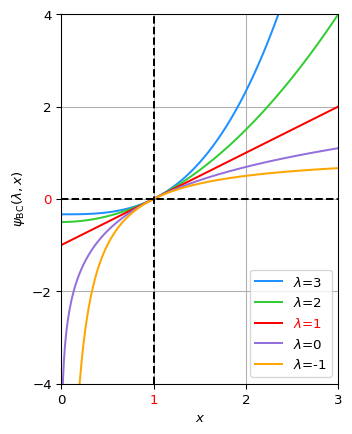
<figcaption>(a) Box-Cox</figcaption>
</figure>
</div>
</div>
</div></td>
<td style="text-align: left;"><div id="cell-fig-yeo-johnson"
class="cell" data-execution_count="3" width="50.0%"
data-layout-align="left">
<div class="cell-output cell-output-display">
<figure id="fig-yeo-johnson">
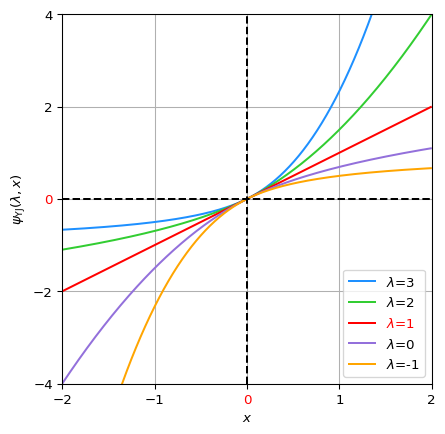
<figcaption>(b) Yeo-Johnson</figcaption>
</figure>
</div>
</div></td>
</tr>
</tbody>
</table>

Figure 1: Box-Cox and Yeo-Johnson transformations.

The optimal $\lambda$ is typically estimated by maximizing the
log-likelihood. For Box-Cox and Yeo-Johnson, the respective
log-likelihood functions are:

<span id="eq-box-cox-llf">$$
\ln\mathcal{L}_{\text{BC}}(\lambda, x)=(\lambda-1) \sum_i^n \ln x_i - \frac{n}{2}\ln\sigma^2_{\psi_{\text{BC}}}
 \qquad(3)$$</span>

<span id="eq-yeo-johnson-llf">$$
\ln\mathcal{L}_{\text{YJ}}(\lambda, x)=(\lambda-1) \sum_i^n \text{sgn} (x_i) \ln(|x_i|+1) - \frac{n}{2}\ln\sigma^2_{\psi_{\text{YJ}}}
 \qquad(4)$$</span>

Here, $\sigma^2_\psi$ represents the variance of the transformed data,
$\text{Var}[\psi(\lambda,x)]$. These log-likelihood functions are
concave (Kouider and Chen 1995; Marchand et al. 2022), which guarantees
a unique maximum. Brent’s method (Brent 2013) is commonly employed for
optimization.

In [4]:
from scipy.optimize import brent

def max_llf(x, llf):
    def _neg_llf(lmb, x):
        return -llf(lmb, x)
    return brent(_neg_llf, args=(x,))

## 2 Numerical Instabilities

Because both transformations involve exponentiation, they are
susceptible to numerical overflow. This problem has been observed by
(Marchand et al. 2022) and discussed in [Scikit-learn’s GitHub
Issue](https://github.com/scikit-learn/scikit-learn/issues/23319). Below
is an example illustrating the problem using a naive implementation of
<a href="#eq-box-cox-llf" class="quarto-xref">Equation 3</a>:

In [5]:
def boxcox_llf_naive(lmb, x):
    n = len(x)
    logx = np.log(x)
    logvar = np.log(np.var(boxcox(x, lmb)))
    return (lmb - 1) * np.sum(logx) - n/2 * logvar

In [6]:
x = np.array([10, 10, 10, 9.9])
print(max_llf(x, llf=boxcox_llf_naive))

156.48528753755807

/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:194: RuntimeWarning:

overflow encountered in multiply

/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:205: RuntimeWarning:

overflow encountered in reduce


Although this returns a $\lambda$ value, it produces overflow warnings.
A useful diagnostic is to visualize the log-likelihood curve:

In [7]:
def plot_llf(x, lb, ub, llf):
    np.set_printoptions(precision=3)
    lmb = np.linspace(lb, ub, 20)
    ll = np.array([llf(l, x) for l in lmb])
    print(f"llf={ll}")

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(lmb, ll)
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel(r"$\ln\mathcal{L}(\lambda, x)$")
    plt.show()

llf=[13.684 13.697 13.711   -inf   -inf   -inf   -inf   -inf   -inf   -inf
   -inf   -inf   -inf   -inf   -inf   -inf   -inf   -inf   -inf   -inf]

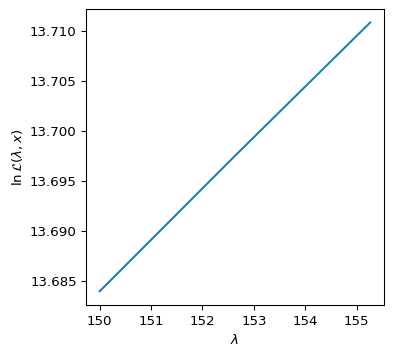

In [8]:
plot_llf(x, lb=150, ub=200, llf=boxcox_llf_naive)

Unfortunately, due to overflow (`np.inf` values), the log-likelihood
curve cannot be visualized in the specified range, suggesting the
returned $\lambda$ is not optimal.

## 3 Existing Solutions

The MASS package in R (Venables and Ripley 2002) proposes a simple yet
effective trick: divide the data by its mean. This rescales the data and
avoids numerical instability without affecting the optimization outcome.

In [9]:
x_dm = x / np.mean(x)
print(max_llf(x_dm, llf=boxcox_llf_naive))

357.55141884289054

llf=[23.376 23.377 23.378 23.38  23.381 23.381 23.382 23.383 23.383 23.383
 23.383 23.383 23.383 23.382 23.382 23.381 23.38  23.379 23.377 23.376]

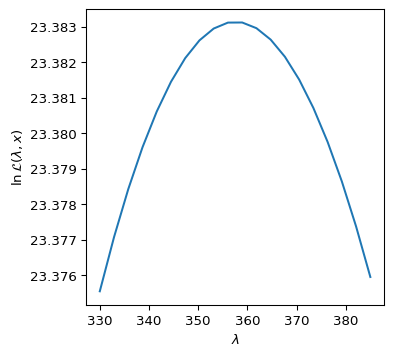

In [10]:
plot_llf(x_dm, lb=330, ub=385, llf=boxcox_llf_naive)

To see why this works, consider the log-variance term for
$\lambda \ne 0$:

<span id="eq-boxcox-log-var">$$
\begin{align*}
\ln\text{Var}[\psi_{\text{BC}}(\lambda,x)]
&=\ln\text{Var}[(x^\lambda-1)/\lambda] \\
&=\ln\text{Var}[x^\lambda/\lambda] \\
&=\ln[\text{Var}(x^\lambda)/\lambda^2] \\
&=\ln\text{Var}(x^\lambda) - 2\ln|\lambda| \\
\end{align*}
 \qquad(5)$$</span>

If $x$ is scaled by a constant $c > 0$:

<span id="eq-boxcox-log-var-mass">$$
\begin{align*}
\ln\text{Var}[\psi_{\text{BC}}(\lambda,x/c)]
&=\ln\text{Var}[(x/c)^\lambda] - 2\ln|\lambda| \\
&=\ln[\text{Var}(x^\lambda)/c^{2\lambda}] - 2\ln|\lambda| \\
&=\ln\text{Var}(x^\lambda) - 2\lambda\ln c  - 2\ln|\lambda| \\
&=\ln\text{Var}[\psi_{\text{BC}}(\lambda,x)] - 2\lambda\ln c \\
\end{align*}
 \qquad(6)$$</span>

Plugging into the log−likelihood:

<span id="eq-boxcox-llf-mass">$$
\begin{align*}
\ln\mathcal{L}_{\text{BC}}(\lambda, x/c)
&=(\lambda-1) \sum_i^n \ln(x_i/c) - \frac{n}{2}\ln\text{Var}[\psi_{\text{BC}}(\lambda,x/c)] \\
&=\ln\mathcal{L}_{\text{BC}}(\lambda, x) - n(\lambda-1)\ln c + n\lambda\ln c \\
&=\ln\mathcal{L}_{\text{BC}}(\lambda, x) + n\ln c \\
\end{align*}
 \qquad(7)$$</span>

The additive constant $n\ln c$ does not affect the maximizer of
$\lambda$. However, this trick does not apply to Yeo-Johnson, where
scaling alters the optimal parameter (see
<a href="#eq-yeo-johnson-llf" class="quarto-xref">Equation 4</a>).

## 4 Log-Space Computation

To address numerical instability for both transformations, log-space
computation (Haberland 2023) is effective. It uses the [Log-Sum-Exp
trick](https://en.wikipedia.org/wiki/LogSumExp) to compute statistics in
log space:

In [11]:
from scipy.special import logsumexp

def log_mean(logx):
    # compute log of mean of x from log(x)
    return logsumexp(logx) - np.log(len(logx))

def log_var(logx):
    # compute log of variance of x from log(x)
    logmean = log_mean(logx)
    pij = np.full_like(logx, np.pi * 1j, dtype=np.complex128)
    logxmu = logsumexp([logx, logmean + pij], axis=0)
    return np.real(logsumexp(2 * logxmu)) - np.log(len(logx))

This allows direct computation of $\ln\sigma^2_\psi$ from $\ln x$.
Plugging in
<a href="#eq-boxcox-log-var" class="quarto-xref">Equation 5</a>, we can
compute the log-likelihood in the log-space.

In [12]:
def boxcox_llf(lmb, x):
    n = len(x)
    logx = np.log(x)
    if lmb == 0:
        logvar = np.log(np.var(logx))
    else:
        logvar = log_var(lmb * logx) - 2 * np.log(abs(lmb))
    return (lmb - 1) * np.sum(logx) - n/2 * logvar

This version avoids overflow and reliably returns the optimal $\lambda$.

In [13]:
print(max_llf(x, llf=boxcox_llf))

357.55141245531865

llf=[14.175 14.177 14.178 14.179 14.18  14.181 14.182 14.182 14.183 14.183
 14.183 14.183 14.182 14.182 14.181 14.18  14.179 14.178 14.177 14.176]

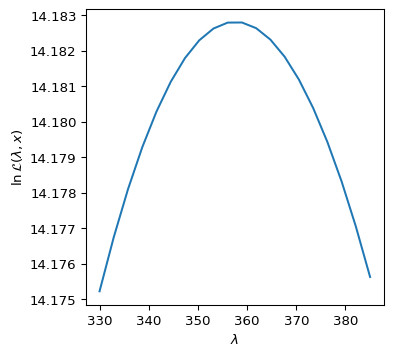

In [14]:
plot_llf(x, lb=330, ub=385, llf=boxcox_llf)

The same principle extends to Yeo-Johnson, even for mixed-sign inputs.

In [15]:
def log_var_yeojohnson(x, lmb):
    if np.all(x >= 0):
        if abs(lmb) < np.spacing(1.0):
            return np.log(np.var(np.log1p(x)))
        return log_var(lmb * np.log1p(x)) - 2 * np.log(abs(lmb))

    elif np.all(x < 0):
        if abs(lmb - 2) < np.spacing(1.0):
            return np.log(np.var(np.log1p(-x)))
        return log_var((2 - lmb) * np.log1p(-x)) - 2 * np.log(abs(2 - lmb))

    else:  # mixed positive and negtive data
        logyj = np.zeros_like(x, dtype=np.complex128)
        pos = x >= 0

        # when x >= 0
        if abs(lmb) < np.spacing(1.0):
            logyj[pos] = np.log(np.log1p(x[pos]) + 0j)
        else:  # lmbda != 0
            logm1_pos = np.full_like(x[pos], np.pi * 1j, dtype=np.complex128)
            logyj[pos] = logsumexp(
                [lmb * np.log1p(x[pos]), logm1_pos], axis=0
            ) - np.log(lmb + 0j)

        # when x < 0
        if abs(lmb - 2) < np.spacing(1.0):
            logyj[~pos] = np.log(-np.log1p(-x[~pos]) + 0j)
        else:  # lmbda != 2
            logm1_neg = np.full_like(x[~pos], np.pi * 1j, dtype=np.complex128)
            logyj[~pos] = logsumexp(
                [(2 - lmb) * np.log1p(-x[~pos]), logm1_neg], axis=0
            ) - np.log(lmb - 2 + 0j)

        return log_var(logyj)

def yeojohnson_llf(lmb, x):
    n = len(x)
    llf = (lmb - 1) * np.sum(np.sign(x) * np.log1p(np.abs(x)))
    llf += -n / 2 * log_var_yeojohnson(x, lmb)
    return llf

## 5 Constrained Optimization

Even with log-space computation, applying the transformation using a
large absolute value of $\lambda$ can result in overflow:

In [16]:
lmax = max_llf(x, llf=boxcox_llf)
print(boxcox(x, lmax))

[inf inf inf inf]

To prevent this, we constrain $\lambda$ so that the transformed values
stay within a safe range.

<span class="theorem-title">**Lemma 1**</span> The transformation
$\psi(\lambda,x)$ is monotonically increasing in both $\lambda$ and $x$
(see I.-K. Yeo 1997 for Yeo-Johnson proof).

This allows us to bound $\lambda$ based on $\min(x)$ and $\max(x)$. For
Box-Cox, we use $x=1$ as a threshold since
$\psi_\text{BC}(\lambda,1)=0$:

<span id="eq-boxcox-constraint">$$
\begin{align*}
\max_\lambda \quad & \ln\mathcal{L}_{\text{BC}}(\lambda, x) \\
\textrm{s.t.} \quad & \text{if } x_{\max}>1, \lambda\le\psi^{-1}_{\text{BC}}(x_{\max},y_{\max}) \\
& \text{if } x_{\min}<1, \lambda\ge\psi^{-1}_{\text{BC}}(x_{\min},-y_{\max}) \\
\end{align*}
 \qquad(8)$$</span>

The inverse Box−Cox function is given by:

<span id="eq-boxcox-inverse">$$
\psi^{-1}_{\text{BC}}(x,y)=-1/y-W(-x^{-1/y}\ln x/y)/\ln x
 \qquad(9)$$</span>

In [17]:
from scipy.special import lambertw

def boxcox_inv_lmbda(x, y):
    num = lambertw(-(x ** (-1 / y)) * np.log(x) / y, k=-1)
    return -1 / y - np.real(num / np.log(x))

In [18]:
def boxcox_constranined_lmax(lmax, x, ymax):
    # x > 1, boxcox(x) > 0; x < 1, boxcox(x) < 0
    xmin, xmax = min(x), max(x)
    if xmin >= 1:
        x_treme = xmax
    elif xmax <= 1:
        x_treme = xmin
    else:  # xmin < 1 < xmax
        indicator = boxcox(xmax, lmax) > abs(boxcox(xmin, lmax))
        x_treme = xmax if indicator else xmin
    
    if abs(boxcox(x_treme, lmax)) > ymax:
        lmax = boxcox_inv_lmbda(x_treme, ymax * np.sign(x_treme - 1))
    return lmax

This method can be verified by testing different values for $y_{\max}$:

In [19]:
def verify_boxcox_constranined_lmax(x):
    np.set_printoptions(precision=3)
    lmax = max_llf(x, llf=boxcox_llf)
    for ymax in [1e300, 1e100, 1e30, 1e10]:
        l = boxcox_constranined_lmax(lmax, x, ymax)
        print(boxcox(x, l))

In [20]:
# Positive overflow
x = np.array([10, 10, 10, 9.9])
verify_boxcox_constranined_lmax(x)

[1.000e+300 1.000e+300 1.000e+300 4.783e+298]
[1.000e+100 1.000e+100 1.000e+100 3.587e+099]
[1.000e+30 1.000e+30 1.000e+30 7.286e+29]
[1.00e+10 1.00e+10 1.00e+10 8.95e+09]

In [21]:
# Negative overflow
x = np.array([0.1, 0.1, 0.1, 0.101])
verify_boxcox_constranined_lmax(x)

[-1.00e+300 -1.00e+300 -1.00e+300 -4.93e+298]
[-1.000e+100 -1.000e+100 -1.000e+100 -3.624e+099]
[-1.000e+30 -1.000e+30 -1.000e+30 -7.309e+29]
[-1.000e+10 -1.000e+10 -1.000e+10 -8.959e+09]

The constrained optimization approach can also be extended to
Yeo-Johnson, ensures overflow-free transformations even for extreme
values.

In [22]:
def yeojohnson_inv_lmbda(x, y):
    if x >= 0:
        num = lambertw(-((x + 1) ** (-1 / y) * np.log1p(x)) / y, k=-1)
        return -1 / y + np.real(-num / np.log1p(x))
    else:
        num = lambertw(((1 - x) ** (1 / y) * np.log1p(-x)) / y, k=-1)
        return -1 / y + 2 + np.real(num / np.log1p(-x))

def yeojohnson_constranined_lmax(lmax, x, ymax):
    # x > 0, yeojohnson(x) > 0; x < 0, yeojohnson(x) < 0
    xmin, xmax = min(x), max(x)
    if xmin >= 0:
        x_treme = xmax
    elif xmax <= 0:
        x_treme = xmin
    else:  # xmin < 0 < xmax
        with np.errstate(over="ignore"):
            indicator = yeojohnson(xmax, lmax) > abs(yeojohnson(xmin, lmax))
        x_treme = xmax if indicator else xmin

    with np.errstate(over="ignore"):
        if abs(yeojohnson(x_treme, lmax)) > ymax:
            lmax = yeojohnson_inv_lmbda(x_treme, ymax * np.sign(x_treme))
    return lmax

Box, G. E. P., and D. R. Cox. 1964. “An Analysis of Transformations.”
*Journal of the Royal Statistical Society: Series B (Methodological)* 26
(2): 211–43. <https://doi.org/10.1111/j.2517-6161.1964.tb00553.x>.

Brent, Richard P. 2013. *Algorithms for Minimization Without
Derivatives*. Dover Books on Mathematics. Dover Publications,
Incorporated.

Haberland, Matt. 2023.
<https://github.com/scipy/scipy/pull/18852#issuecomment-1657858886>.

Kouider, Elies, and Hanfeng Chen. 1995. “Concavity of Box-Cox
Log-Likelihood Function.” *Statistics & Probability Letters* 25 (2):
171–75. <https://doi.org/10.1016/0167-7152(94)00219-X>.

Marchand, Tanguy, Boris Muzellec, Constance Béguier, Jean Ogier du
Terrail, and Mathieu Andreux. 2022. “SecureFedYJ: A Safe Feature
Gaussianization Protocol for Federated Learning.” In *Advances in Neural
Information Processing Systems*, 35:36585–98. Curran Associates, Inc.
<https://doi.org/10.48550/arXiv.2210.01639>.

Venables, W. N., and B. D. Ripley. 2002. *Modern Applied Statistics with
s*. Fourth. New York: Springer.
<https://doi.org/10.32614/CRAN.package.MASS>.

Yeo, In-Kwon. 1997. “A New Family of Power Transformations to Reduce
Skewness or Approximate Normality.” PhD thesis, The University of
Wisconsin-Madison.
<https://www.proquest.com/openview/b7835693052aecd65e635d39a6bd099a/>.

Yeo, In‐Kwon, and Richard A. Johnson. 2000. “A New Family of Power
Transformations to Improve Normality or Symmetry.” *Biometrika* 87 (4):
954–59. <https://doi.org/10.1093/biomet/87.4.954>.